### Amazon Review를 이용한 추천 시스템 실습 - suprise 패키지 사용

[블로그 링크](simonezz.tistory.com/42)



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# 데이터 불러오기
electronics_data=pd.read_csv("ratings_Electronics (1).csv", names=['userId', 'productId', 'Rating','timestamp'])

In [3]:
# 데이터 모양 확인
print(electronics_data.head())
print(electronics_data.shape)

           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
(7824482, 4)


In [4]:
# 데이터 자르기
electronics_data=electronics_data.iloc[:1048576, 0:]

In [5]:
# 데이터 타입 확인
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [6]:
electronics_data.describe()['Rating']

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [7]:
# 평가 range 결정하기
print("max of rating : %d" %(electronics_data.Rating.max()))
print("min of rating : %d" %(electronics_data.Rating.min()))

max of rating : 5
min of rating : 1


### Missing values 수

In [8]:
print("Numbe of missing values across columns: \n", electronics_data.isnull().sum())

Numbe of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


### Ratings

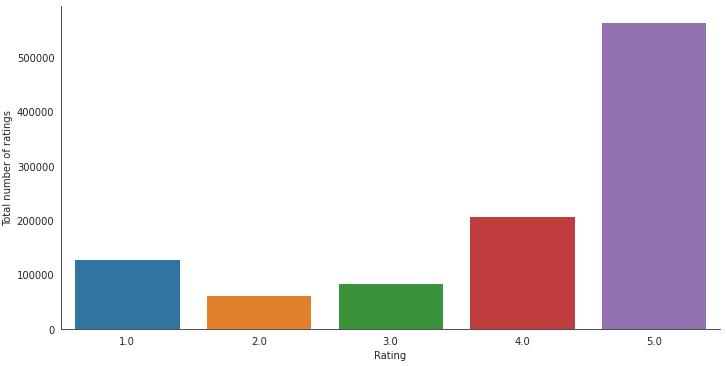

In [9]:
with sns.axes_style("white"):
    g = sns.factorplot("Rating", data=electronics_data, 
                      aspect=2.0, kind="count")
    g.set_ylabels("Total number of ratings")

In [10]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings:" , electronics_data.shape[0])
print("Total num of Users: ", len(np.unique(electronics_data.userId)))
print("Total num of products: ", len(np.unique(electronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings: 1048576
Total num of Users:  786330
Total num of products:  61894


In [11]:
# 의미 없는 column 버리기
electronics_data.drop(['timestamp'], axis=1, inplace=True)

In [12]:
electronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Ratings 분석

In [13]:
num_of_rated_products_per_user=electronics_data.groupby(by="userId")['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head() # 평가를 많이한 혹은 높은 점수를 준 사람 순서

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [14]:
num_of_rated_products_per_user.describe()
# 대부분 user 당 하나의 product에만 평가함

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [15]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

# 각각에 해당하는 백분위수 입력하고 각 백분위 수에 맞는 quantile 반환
# interpolation: 보간 방법>> 큰거로!

In [16]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

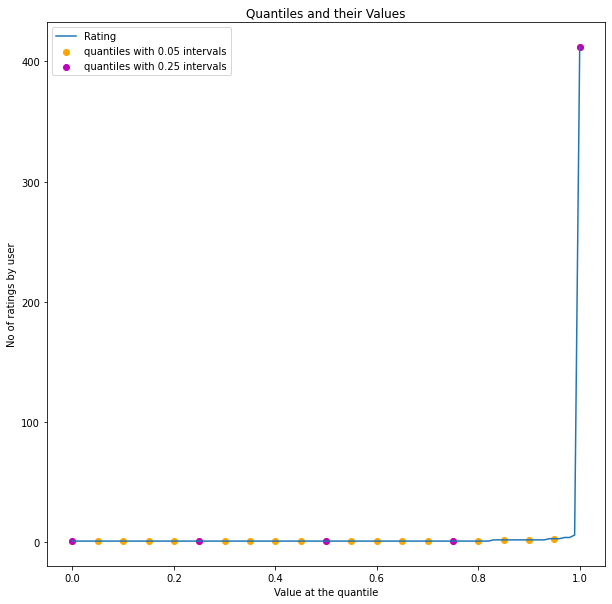

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()

#qunatiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best') # 알아서 최적의 위치를 계산하여 삽입한다
plt.show()

In [18]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



### Popularity Based Recommendation
: 가장 많이 구입되거나 높게 평가된 아이템들을 추천함. 개인에 맞는 추천 시스템은 아님

In [19]:
# 평가가 50번 이상된 상품들을 가져옴
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [20]:
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [21]:
new_df.shape

(677947, 3)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

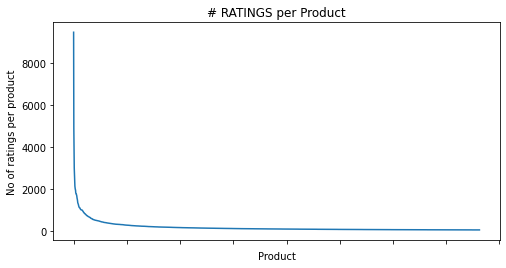

In [22]:
num_of_ratings_per_product=new_df.groupby(by="productId")['Rating'].count().sort_values(ascending=False)

fig=plt.figure(figsize=plt.figaspect(.5)) # 그래프 크기를 0.5만큼 확대(즉 축소되는것)
ax=plt.gca() # 현재의 사이즈를 반환
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [23]:
# 평가들을 상품 아이디로 묶고 각 상품의 평균 평점을 낸다
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [24]:
# 평균 높은것부터 출력
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [25]:
# 평가 된 수 기준 정렬
new_df.groupby("productId")['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [26]:
# 평점 평균을 이용하여 dataFrame 만들기
ratings_mean_count=pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [27]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [28]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [29]:
ratings_mean_count['rating_counts'].max() # rating수가 가장 많은 거

9487

<Figure size 432x432 with 0 Axes>

<AxesSubplot:>

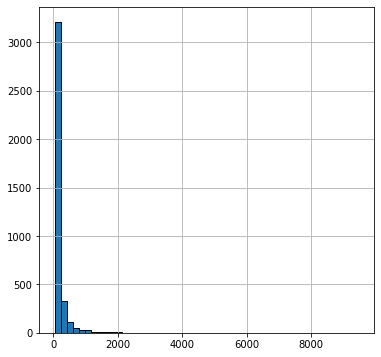

In [30]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True # 테두리 지정: default black
ratings_mean_count['rating_counts'].hist(bins=50) # 리뷰수

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

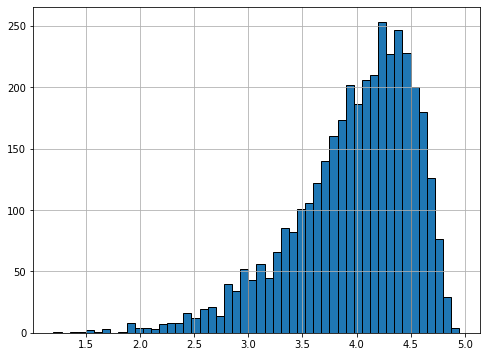

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True 
ratings_mean_count['Rating'].hist(bins=50) #평점 평균

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

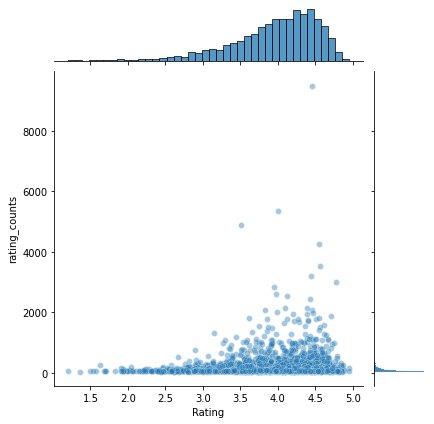

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

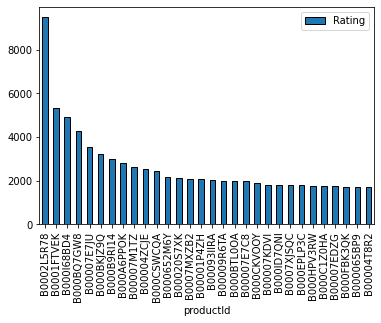

In [33]:
popular_products=pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular=popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind='bar')
# 리뷰수가 가장 많은 제품의 히스토그램

## Collaborative Filtering

In [34]:
!pip3 install surprise

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-win_amd64.whl size=728675 sha256=847d582ef9ecfd055924c56280635198128c2b69016a088aafe59cf6912f75a6
  Stored in directory: c:\users\정서우\appdata\local\pip\cache\wheels\20\91\57\2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise


In [35]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

KNN model: https://danthetech.netlify.app/DataScience/how-does-recommendation-algorithms-work-using-surpriselib

KNNWithMeans: KNNBasic과 차이점은 k명의 유사 사용자들이 영화 i에 대해 평가한 평점들을 그대로 가중합하지않고,

r-mu
 
를 가중합하게 된다. 그리고 최종적으로는 우리가 영화 i에대해 예측하려는 사용자 U의 평균을 더해주는 방법으로 사용자 U의 특성을 좀 더 부가하는 방법을 쓰고 있다. 예를들어 U는 원래 평점을 조금 낮게주는 스타일이어서 정말 재밌다고 느끼는 영화에도 4점을 준다고 가정해보자. 이 경우에 k명의 유사 유저들이 영화 i에 대해 다 5점을 줬단 이유로 5점에 가까운 예측 값이 나오게 된다면 문제가 발생할 수 있게 되는 것이다. KNNwithMeans에서는 이런 경우를 조금 더 방지할 수 있게 된다.

In [38]:
# 데이터 가져오기
reader=Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df, reader)

In [40]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

In [41]:
## KNN을 이용 trainset에 파라미터 맞추기
algo = KNNWithMeans(k=5, sim_options = {'name': 'pearson_baseline', 'user_based':False})
# 'name': 사용할 유사도 이름, 'user_based': user base인지 item base인지 결정
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [42]:
## Test accuracy 측정
test_pred = algo.test(testset)
print("Item-based Model: Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model: Test Set
RMSE: 1.3436


1.343641161111319

## Model-based collaborative filtering system

: 대량의 상품, 많은 사용자들에게 추천 가능, sparse한 matrices에도 사용가능

In [43]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns= 'productId', fill_value=0) # 사용자-아이템
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
ratings_matrix.shape

(9832, 76)

In [45]:
X=ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
print(X.shape)
print()
print(X.index)

(76, 9832)

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', '

In [47]:
X1 = X

In [48]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components = 10) # 차원 축소
decomposed_matrix=SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [49]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54677986e-01,  2.44500909e-02,
         2.98758948e-04, -1.34215280e-01, -4.69735953e-05,
         4.58425485e-02,  1.50141387e-04,  4.77761844e-03,
        -8.17480865e-02],
       [ 6.69637952e-04,  1.29163782e+00,  1.49561155e+00,
         2.02588952e-01, -3.63646063e-03,  2.73411878e-02,
         1.20988906e-02,  4.02931574e-02,  6.12906805e+01,
         2.01143543e+00],
       [ 7.21047851e-06,  1.06800194e-01,  3.23668228e-01,
        -3.28834898e-04, -2.25710199e-03,  1.13281240e-02,
        -3.48112380e-03, -3.74484052e-02,  9.64555323e-01,
        -1.74335340e-01],
       [ 6.02361701e-04,  7.56084275e-01,  5.47594343e-01,
        -2.90747471e-02, -3.31112116e-02,  1.03333590e-01,
        -1.10470702e-01,  1.55629366e-01,  4.16684187e+00,
         7.36930697e-01],
       [ 5.49858387e-04,  7.98769605e-01,  1.01043655e+00,
         8.80052796e-02,  4.17118376e-02, -1.45599206e-01,
         2.74037481e-01, -6.01761304e-01,  1.12181848e+00,
        -1.

In [50]:
correlation_matrix=np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [52]:
X.index[75]

'B00000K135'

In [53]:
i = X.index[75]

product_names=list(X.index)
product_ID = product_names.index(i) #index 구하기
product_ID

75

In [57]:
# 한 product_ID(75)와의 상관관계
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [58]:
correlation_product_ID 

array([ 0.04037138,  0.61197867,  0.52758748,  0.60652781,  0.33298078,
       -0.01911007, -0.12082963,  0.55772001,  0.58013125, -0.48376379,
        0.54311522, -0.57461444, -0.36940171,  0.52907048,  0.49942829,
       -0.86584709,  0.64873199,  0.88265538, -0.06559356,  0.18331506,
        0.42412919, -0.40791136,  0.10457913, -0.44386213, -0.80908458,
       -0.45435647,  0.16500676, -0.41771333, -0.41540077, -0.79567962,
        0.63680663, -0.53056877, -0.47808235,  0.598715  , -0.80669329,
       -0.44498988,  0.05380175, -0.22677354,  0.18177737,  0.66316098,
       -0.02185749,  0.3695218 , -0.27357499,  0.02805294, -0.03192793,
        0.16987182,  0.14354876, -0.0459849 , -0.83065642,  0.29594828,
       -0.3945296 ,  0.58263216, -0.38002239,  0.76909834, -0.45989877,
        0.25276287, -0.39119552, -0.79088098, -0.95676161, -0.62582765,
       -0.59493594, -0.0942944 ,  0.33367917, -0.0955992 ,  0.76902351,
        0.46193753, -0.62988826,  0.44779493, -0.02109749,  0.34

In [63]:
Recommend = list(X.index[abs(correlation_product_ID) > 0.65]) # 상관계수 0.65보다 큰 상품들의 index의 list return

Recommend.remove(i) #이미 구입한 상품은 뺀다

Recommend[0:24] #상위 24개 추천

['9575871979',
 '9888002198',
 'B000001OMI',
 'B00000J061',
 'B00000J1EJ',
 'B00000J1QK',
 'B00000J3Q7',
 'B00000J4GE',
 'B00000JBPB',
 'B00000JCT8',
 'B00000JFE3',
 'B00000JPPI']

In [64]:
Recommend

['9575871979',
 '9888002198',
 'B000001OMI',
 'B00000J061',
 'B00000J1EJ',
 'B00000J1QK',
 'B00000J3Q7',
 'B00000J4GE',
 'B00000JBPB',
 'B00000JCT8',
 'B00000JFE3',
 'B00000JPPI']